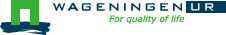



# Getting Started with PCSE/WOFOST

This Jupyter notebook will introduce PCSE and explain the basics of running models with PCSE, taking WOFOST as an example.

Allard de Wit, March 2018

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. `PCSE` and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. `pandas` for processing and storing WOFOST output;
  3. `matplotlib` for generating charts


## Importing the relevant modules


In [2]:
%matplotlib inline
import sys, os
import pcse
import pandas
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.6.7 |Anaconda, Inc.| (default, Oct 24 2018, 09:45:24) [MSC v.1912 64 bit (AMD64)] 
PCSE version: 5.4.2


## Starting from the internal demo database
For demonstration purposes, we can start WOFOST with a single function call. This function reads all relevant data from the internal demo databases. In the next notebook we will demonstrate how to read data from external sources.

The command below starts WOFOST in potential production mode for winter-wheat for a location in Southern Spain.

In [3]:
wofostPP = pcse.start_wofost(mode="pp")

[INFO] - Successfully retrieved site variables from database
[INFO] - Succesfully retrieved crop parameter values from database
[INFO] - Succesfully retrieved soil parameter values from database
[INFO] - Succesfully retrieved location information from 'grid' table for grid 31031
[WARNING] - Only 731 records selected from table 'grid_weather' for grid 31031, period 0001-01-01 -- 9999-01-01.
[INFO] - Successfully retrieved weather data from 'grid_weather' table for grid 31031 between 0001-01-01 and 9999-01-01
[INFO] - Starting crop (undefined) with variety (undefined_31031_2000) on day 2000-01-01


You have just successfully initialized a PCSE/WOFOST object in the Python interpreter, which is in its initial state and waiting to do some simulation. We can now advance the model state for example with 1 day:


In [4]:
wofostPP.run()

Advancing the crop simulation with only 1 day, is often not so useful so the number of days to simulate can be specified as well:

In [5]:
wofostPP.run(days=10)

## Getting information about state and rate variables
Retrieving information about the calculated model states or rates can be done with the `get_variable()` method on a PCSE object. For example, to retrieve the leaf area index value in the current model state you can do:

In [6]:
wofostPP.get_variable("LAI")


0.2870809817505803

In [7]:
wofostPP.run(days=50)
wofostPP.get_variable("LAI")

5.237860682697476

In [8]:
wofostPP.set_variable("LAI", 4.0)

{'LAI': -1.2378606826974758,
 'LAISUM': -1.2378606826974758,
 'WLV': -583.8965484422083,
 'TWLV': -583.8965484422083}

Showing that after 11 days the LAI value is 0.287. When we increase time with another 25 days, the LAI increases to 1.528. The get_variable method can retrieve any state or rate variable that is defined somewhere in the model. 

Finally, we can finish the crop season by letting it run until the model terminates because the crop reaches maturity or the harvest date:

In [9]:
wofostPP.run_till_terminate()

[INFO] - Changed phenological stage 'vegetative' to 'reproductive' on 2000-03-28
[INFO] - Changed phenological stage 'reproductive' to 'mature' on 2000-05-31


## Retrieving and displaying WOFOST output
We can retrieve the results of the simulation at each time step using  `get_output()`. In python terms this returns a list of dictionaries, one dictionary for each time step of the the simulation results. Each dictionary contains the key:value pairs of the state or rate variables that were stored at that time step.



In [10]:
output = wofostPP.get_output()

The most convenient way to handle the output from WOFOST is to used the `pandas` module to convert it into a dataframe. Pandas DataFrames can be converted to a variety of formats including excel, CSV or database tables.

In [11]:
dfPP = pandas.DataFrame(output).set_index("day")
dfPP.head()

,DVS,LAI,RD,SM,TAGP,TRA,TWLV,TWRT,TWSO,TWST,WWLOW
day,,,,,,,,,,,
2000-01-01,0.000000,0.144690,10.0,0.3175,105.000000,0.005768,68.250000,105.000000,0.0,36.750000,None
2000-01-02,0.008867,0.154184,11.2,0.3175,111.889710,0.003312,72.728312,111.889710,0.0,39.161399,None
2000-01-03,0.017157,0.164025,12.4,0.3175,119.031178,0.002589,77.370266,119.031178,0.0,41.660912,None
2000-01-04,0.024293,0.173908,13.6,0.3175,126.203520,0.006309,82.032288,126.203520,0.0,44.171232,None
2000-01-05,0.032706,0.185033,14.8,0.3175,134.276367,0.003616,87.279639,134.276367,0.0,46.996729,None


Besides the output at each time step, WOFOST also provides summary output which summarizes the crop cycle and provides you the total crop biomass, total yield, maximum LAI and other variables. In case of crop rotations, the summary output will consist of several sets of variables, one for each crop cycle.

In [12]:
summary_output = wofostPP.get_summary_output()
msg = "Reached maturity at {DOM} with total biomass {TAGP:.1f} kg/ha, " \
      "a yield of {TWSO:.1f} kg/ha with a maximum LAI of {LAIMAX:.2f}."
for crop_cycle in summary_output:
    print(msg.format(**crop_cycle))

Reached maturity at 2000-05-31 with total biomass 17066.2 kg/ha, a yield of 8345.2 kg/ha with a maximum LAI of 5.35.


## Visualizing output
The pandas module is also very useful for generating charts from simulation results. In this case we generate graphs of leaf area index and crop biomass including total biomass and grain yield.

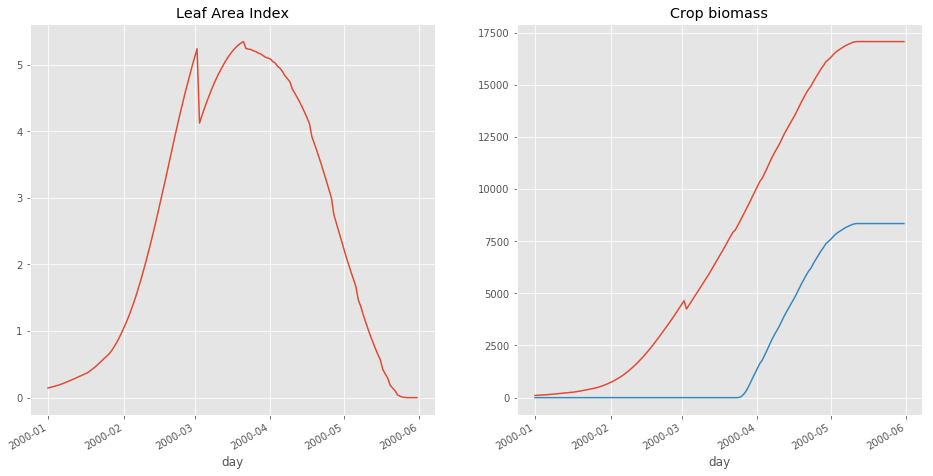

In [13]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
dfPP.LAI.plot(ax=axis1, label="LAI")
dfPP.TAGP.plot(ax=axis2, label="Total biomass")
dfPP.TWSO.plot(ax=axis2, label="Yield")
axis1.set_title("Leaf Area Index")
axis2.set_title("Crop biomass")
fig.autofmt_xdate()